In [22]:
from mnist import MNIST
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras_tuner.tuners import RandomSearch
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from keras.layers import Flatten, Activation, Dropout, Dense
import keras_tuner as kt 



In [3]:
mndata = MNIST('mnist')

X_train, y_train = mndata.load_training()
X_test, y_test = mndata.load_testing()
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)


X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

print("Train matrix shape", X_train.shape)
print("Test matrix shape", X_test.shape)


"""
(b) Split the training dataset into sub training and validation sets randomly. Use 1
6 of training dataset as validation set. Use the ‘accuracy’ as metric. 
"""


X_subtrain, X_valid, y_subtrain, y_valid = train_test_split(X_train, y_train, test_size=0.16, random_state=42)


# one-hot encoding of y_train, y_test, y_subtrain, y_valid
n_classes = 10
print("Shape of y_train before one-hot encoding: ", y_train.shape)
y_train = to_categorical(y_train, n_classes)
y_test = to_categorical(y_test, n_classes)
print("Shape of y_test after one-hot encoding: ", y_test.shape)
y_subtrain = to_categorical(y_subtrain, n_classes)
y_valid = to_categorical(y_valid, n_classes)
print("Shape of y_subtrain after one-hot encoding: ", y_subtrain.shape)
print("Shape of y_valid after one-hot encoding: ", y_valid.shape)


Train matrix shape (60000, 784)
Test matrix shape (10000, 784)
Shape of y_train before one-hot encoding:  (60000,)
Shape of y_test after one-hot encoding:  (10000, 10)
Shape of y_subtrain after one-hot encoding:  (50400, 10)
Shape of y_valid after one-hot encoding:  (9600, 10)


In [4]:
"""
Please repeat 10 times of random split for each hyper-parameters and architecture, and aggregate
(average) the accuracy.
"""

# building a linear stack of layers with the sequential model
model = Sequential()
model.add(Dense(32, input_shape=(784,)))
model.add(Activation('relu'))                            


model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
history = model.fit(X_subtrain, y_subtrain, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
1575/1575 [==============================] - 6s 3ms/step - loss: 0.3754 - accuracy: 0.8965 - val_loss: 0.2314 - val_accuracy: 0.9319
Epoch 2/10
1575/1575 [==============================] - 4s 3ms/step - loss: 0.2054 - accuracy: 0.9414 - val_loss: 0.1809 - val_accuracy: 0.9436
Epoch 3/10
1575/1575 [==============================] - 4s 3ms/step - loss: 0.1638 - accuracy: 0.9529 - val_loss: 0.1632 - val_accuracy: 0.9499
Epoch 4/10
1575/1575 [==============================] - 5s 3ms/step - loss: 0.1363 - accuracy: 0.9601 - val_loss: 0.1374 - val_accuracy: 0.9603
Epoch 5/10
1575/1575 [==============================] - 6s 4ms/step - loss: 0.1162 - accuracy: 0.9655 - val_loss: 0.1357 - val_accuracy: 0.9594
Epoch 6/10
1575/1575 [==============================] - 7s 4ms/step - loss: 0.1032 - accuracy: 0.9691 - val_loss: 0.1256 - val_accuracy: 0.9624
Epoch 7/10
1575/1575 [==============================] - 4s 3ms/step - loss: 0.0929 - accuracy: 0.9723 - val_loss: 0.1215 - val_accuracy:

In [5]:
# Average accuracy
sum(history.history['accuracy']) / len(history.history['accuracy'])

0.9587777853012085

'\nc) (20 points) Optimizer evaluation\n• Implement a neural network which has single hidden layer with 32 units. Using the network, find best hyper-parameters of the following optimizers; SGD,\nRMSprop, Adam, Adagrad.\n• Train the network with the training dataset (not sub training) with the best\nhyper-parameters of each optimizer.\n• For each optimizer, report test accuracy using the test dataset.\n'

In [30]:
"""
(c) (20 points) Optimizer evaluation
• Implement a neural network which has single hidden layer with 32 units. Using the network, find best hyper-parameters of the following 
optimizers; SGD, RMSprop, Adam, Adagrad.
• Train the network with the training dataset (not sub training) with the best
hyper-parameters of each optimizer.
• For each optimizer, report test accuracy using the test dataset.
"""

# tuning adam_model

def adam_model(hp):
    tuned_model = Sequential()
    tuned_model.add(Dense(32, Flatten(input_shape=(784,))))
    tuned_model.add(Dense(10))
    tuned_model.add(Activation('softmax'))


    tuned_model.compile(
        optimizer = keras.optimizers.Adam(
            hp.Choice('lr', values=[0.001, 0.01, 0.1])
        ),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return tuned_model



adam_tuner = RandomSearch(
    adam_model,
    objective='val_accuracy',
    max_trials=2,
    executions_per_trial=2,
    directory='my_dir',
    project_name='AI_assg5_12'
)


# tuner.search(X_train, y_train, epochs=2, validation_data=(X_test, y_test))
adam_tuner.search(X_subtrain, y_subtrain, epochs=5, validation_data=(X_valid, y_valid))
adam_tuner.results_summary()







INFO:tensorflow:Reloading Oracle from existing project my_dir\AI_assg5_12\oracle.json
INFO:tensorflow:Reloading Tuner from my_dir\AI_assg5_12\tuner0.json
INFO:tensorflow:Oracle triggered exit
Results summary
Results in my_dir\AI_assg5_12
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
lr: 0.01
Score: 0.8998437523841858
Trial summary
Hyperparameters:
lr: 0.1
Score: 0.863177090883255


In [31]:
"""
Train the network with the training dataset (not sub training) with the best
hyper-parameters of each optimizer. For each optimizer, report test accuracy using the test dataset.
"""

# adam optimizer - training the model using best learning rate of 0.01 and evaluating on test data

hp = kt.HyperParameters()
hp.values['lr'] = 0.01
adam_model = adam_model(hp)
history = adam_model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))
adam_model.evaluate(X_test, y_test)

Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0893 - accuracy: 0.8834 - val_loss: 0.0777 - val_accuracy: 0.9020
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0800 - accuracy: 0.8979 - val_loss: 0.0813 - val_accuracy: 0.8939
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0782 - accuracy: 0.9017 - val_loss: 0.0749 - val_accuracy: 0.9038
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0764 - accuracy: 0.9035 - val_loss: 0.0744 - val_accuracy: 0.9033
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0753 - accuracy: 0.9051 - val_loss: 0.0725 - val_accuracy: 0.9082
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0751 - accuracy: 0.9051 - val_loss: 0.0726 - val_accuracy: 0.9143
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0749 - accuracy: 0.9062 - val_loss: 0.0763 - val_accuracy:

[0.07389047741889954, 0.90829998254776]

In [8]:
# tuning RMSprop_model

def RMSprop_model(hp):
    tuned_model = Sequential()
    tuned_model.add(Dense(32, Flatten(input_shape=(784,))))
    tuned_model.add(Dense(10))
    tuned_model.add(Activation('softmax'))


    tuned_model.compile(
        optimizer = keras.optimizers.RMSprop(
            hp.Choice('lr', values=[0.001, 0.01, 0.1])
        ),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return tuned_model

RMSprop_tuner = RandomSearch(
    RMSprop_model,
    objective='val_accuracy',
    max_trials=2,
    executions_per_trial=2,
    directory='my_dir',
    project_name='AI_assg5_2'
)

RMSprop_tuner.search(X_subtrain, y_subtrain, epochs=5, validation_data=(X_valid, y_valid))
RMSprop_tuner.results_summary()







INFO:tensorflow:Reloading Oracle from existing project my_dir\AI_assg5_2\oracle.json
INFO:tensorflow:Reloading Tuner from my_dir\AI_assg5_2\tuner0.json
INFO:tensorflow:Oracle triggered exit
Results summary
Results in my_dir\AI_assg5_2
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
lr: 0.001
Score: 0.9138541519641876
Trial summary
Hyperparameters:
lr: 0.01
Score: 0.9013020694255829


In [26]:
# RMSprop optimizer - training the model using best learning rate of 0.001 and evaluating on test data

hp = kt.HyperParameters()
hp.values['lr'] = 0.001
RMSprop_model = RMSprop_model(hp)
history = RMSprop_model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))
RMSprop_model.evaluate(X_test, y_test)

Epoch 1/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.0904 - accuracy: 0.8812 - val_loss: 0.0692 - val_accuracy: 0.9106
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0696 - accuracy: 0.9098 - val_loss: 0.0658 - val_accuracy: 0.9149
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0673 - accuracy: 0.9139 - val_loss: 0.0646 - val_accuracy: 0.9179
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0662 - accuracy: 0.9161 - val_loss: 0.0649 - val_accuracy: 0.9154
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0657 - accuracy: 0.9173 - val_loss: 0.0661 - val_accuracy: 0.9162
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0655 - accuracy: 0.9174 - val_loss: 0.0651 - val_accuracy: 0.9211
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0652 - accuracy: 0.9182 - val_loss: 0.0665 - val_accuracy:

[0.06679161638021469, 0.9136999845504761]

In [9]:
# tuning SGD_model 

def SGD_model(hp):
    tuned_model = Sequential()
    tuned_model.add(Dense(32, Flatten(input_shape=(784,))))
    tuned_model.add(Dense(10))
    tuned_model.add(Activation('softmax'))


    tuned_model.compile(
        optimizer = keras.optimizers.SGD(
            hp.Choice('lr', values=[0.001, 0.01, 0.1])
        ),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return tuned_model

SGD_tuner = RandomSearch(
    SGD_model,
    objective='val_accuracy',
    max_trials=2,
    executions_per_trial=3,
    directory='my_dir',
    project_name='AI_assg5_31'
)

SGD_tuner.search(X_subtrain, y_subtrain, epochs=5, validation_data=(X_valid, y_valid))
SGD_tuner.results_summary()

INFO:tensorflow:Reloading Oracle from existing project my_dir\AI_assg5_31\oracle.json
INFO:tensorflow:Reloading Tuner from my_dir\AI_assg5_31\tuner0.json
INFO:tensorflow:Oracle triggered exit
Results summary
Results in my_dir\AI_assg5_31
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
lr: 0.1
Score: 0.9045486052831014
Trial summary
Hyperparameters:
lr: 0.01
Score: 0.8551041682561239


In [27]:
# SGD optimizer - training the model using best learning rate of 0.1 and evaluating on test data

hp = kt.HyperParameters()
hp.values['lr'] = 0.1
SGD_model = SGD_model(hp)
history = SGD_model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))
SGD_model.evaluate(X_test, y_test)

Epoch 1/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.1307 - accuracy: 0.8292 - val_loss: 0.0877 - val_accuracy: 0.8920
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0845 - accuracy: 0.8903 - val_loss: 0.0756 - val_accuracy: 0.9058
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0768 - accuracy: 0.8986 - val_loss: 0.0714 - val_accuracy: 0.9049
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0732 - accuracy: 0.9026 - val_loss: 0.0687 - val_accuracy: 0.9126
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0711 - accuracy: 0.9066 - val_loss: 0.0680 - val_accuracy: 0.9120
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0697 - accuracy: 0.9087 - val_loss: 0.0665 - val_accuracy: 0.9140
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0686 - accuracy: 0.9106 - val_loss: 0.0670 - val_accuracy:

[0.06513335555791855, 0.9147999882698059]

In [24]:
# tuning adagrad_model

def adagrad_model(hp):
    tuned_model = Sequential()
    tuned_model.add(Dense(32, Flatten(input_shape=(784,))))
    tuned_model.add(Dense(10))
    tuned_model.add(Activation('softmax'))


    tuned_model.compile(
        optimizer = keras.optimizers.Adagrad(
            hp.Choice('lr', values=[0.001, 0.01, 0.1])
        ),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return tuned_model

adagrad_tuner = RandomSearch(
    adagrad_model,
    objective='val_accuracy',
    max_trials=2,
    executions_per_trial=2,
    directory='my_dir',
    project_name='AI_assg5_5'
)

adagrad_tuner.search(X_subtrain, y_subtrain, epochs=5, validation_data=(X_valid, y_valid))
adagrad_tuner.results_summary()

INFO:tensorflow:Reloading Oracle from existing project my_dir\AI_assg5_5\oracle.json
INFO:tensorflow:Reloading Tuner from my_dir\AI_assg5_5\tuner0.json
INFO:tensorflow:Oracle triggered exit
Results summary
Results in my_dir\AI_assg5_5
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
lr: 0.1
Score: 0.9118229150772095
Trial summary
Hyperparameters:
lr: 0.001
Score: 0.7615624964237213


In [25]:
# adagrad optimizer - training the model using best learning rate of 0.1 and evaluating on test data

# adagrad_model = Sequential()
# adagrad_model.add(Dense(32, input_shape=(784,)))
# adagrad_model.add(Activation('relu'))                            
# adagrad_model.add(Dense(10))
# adagrad_model.add(Activation('softmax'))

hp = kt.HyperParameters()
hp.values['lr'] = 0.1
adagrad_model = adagrad_model(hp)
history = adagrad_model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))
adagrad_model.evaluate(X_test, y_test)

Epoch 1/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.0977 - accuracy: 0.8719 - val_loss: 0.0723 - val_accuracy: 0.9070
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0731 - accuracy: 0.9042 - val_loss: 0.0696 - val_accuracy: 0.9121
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0697 - accuracy: 0.9097 - val_loss: 0.0667 - val_accuracy: 0.9129
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0680 - accuracy: 0.9115 - val_loss: 0.0689 - val_accuracy: 0.9097
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0671 - accuracy: 0.9135 - val_loss: 0.0648 - val_accuracy: 0.9164
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0663 - accuracy: 0.9151 - val_loss: 0.0642 - val_accuracy: 0.9175
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0657 - accuracy: 0.9156 - val_loss: 0.0647 - val_accuracy:

[0.0645749419927597, 0.9197999835014343]

In [35]:
"""
(d) (20 points) Architecture evaluation
• Pick the best optimizer and it’s hyper-parameters from the previous part.
• Using sub training and validation datasets, find the best architecture in terms
of the number of layers, the number of units, and activation functions.
• Report 3 best architectures in terms of test accuracy. Please include architecture diagram as shown in Figure 1.
"""

# best model - RMSprop_model, accuracy - 0.96, lr = 0.001

def best_model(hp):
    tuned_model = Sequential()
    tuned_model.add(Flatten(input_shape=(784,)))

    for i in range(hp.Int('num_of_layers',2,5)):         
        #providing range for number of neurons in hidden layers
        tuned_model.add(Dense(units=hp.Int('num_of_neurons'+ str(i),min_value=32,max_value=128,step=32),
                                    activation=hp.Choice('activation_function' + str(i), values=['relu', 'tanh', 'sigmoid'], default='relu')))

    tuned_model.add(Dense(10))
    tuned_model.add(Activation('softmax'))


    tuned_model.compile(
        optimizer = keras.optimizers.RMSprop(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return tuned_model

best_tuner = RandomSearch(
    best_model,
    objective='val_accuracy',
    max_trials=3,
    executions_per_trial=3,
    directory='my_dir',
    project_name='AI_assg5_67'
)

best_tuner.search(X_subtrain, y_subtrain, epochs=5, validation_data=(X_valid, y_valid))
best_tuner.results_summary()

Trial 3 Complete [00h 01m 02s]
val_accuracy: 0.9696875015894572

Best val_accuracy So Far: 0.972083330154419
Total elapsed time: 00h 03m 31s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in my_dir\AI_assg5_67
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
num_of_layers: 5
num_of_neurons0: 96
activation_function0: relu
num_of_neurons1: 64
activation_function1: relu
num_of_neurons2: 96
activation_function2: sigmoid
num_of_neurons3: 32
activation_function3: relu
num_of_neurons4: 32
activation_function4: relu
Score: 0.972083330154419
Trial summary
Hyperparameters:
num_of_layers: 3
num_of_neurons0: 96
activation_function0: relu
num_of_neurons1: 32
activation_function1: sigmoid
num_of_neurons2: 96
activation_function2: sigmoid
num_of_neurons3: 96
activation_function3: tanh
num_of_neurons4: 32
activation_function4: sigmoid
Score: 0.9696875015894572
Trial summary
Hyperparameters:
num_of_layers: 3
num_of_neurons0: 128
activa

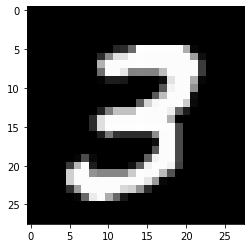

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


In [97]:


id = 7

image = np.array(X_train[id], dtype='float')
pixels = image.reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()

# print(X_train[id])
print(y_train[id])